In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
!pip install nltk
!pip install nltk matplotlib
train_df = pd.read_csv("train.csv", on_bad_lines='skip')  # Skip bad lines
val_df = pd.read_csv("val.csv", on_bad_lines='skip')  # Skip bad lines
test_df = pd.read_csv("test.csv", on_bad_lines='skip')
merged_df = pd.concat([train_df, val_df, test_df], ignore_index=True)

Frist method : BERT pre-trained

In [ ]:
# Install CUDA Toolkit
!wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/cuda-11-0_11.0.3-1_amd64.deb
!dpkg -i cuda-11-0_11.0.3-1_amd64.deb
!apt-key adv --fetch-keys https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/7fa2af80.pub
!apt-get update
!apt-get install cuda

# Install cuDNN (adjust version accordingly)
!wget https://developer.download.nvidia.com/compute/redist/cudnn/v8.0.5/cudnn-11.0-linux-x64-v8.0.5.39.tgz
!tar -xzvf cudnn-11.0-linux-x64-v8.0.5.39.tgz
!cp cuda/include/cudnn*.h /usr/local/cuda/include
!cp cuda/lib64/libcudnn* /usr/local/cuda/lib64
!chmod a+r /usr/local/cuda/include/cudnn*.h /usr/local/cuda/lib64/libcudnn*

!nvidia-smi

import torch
torch.cuda.is_available()

--2025-01-20 03:52:26--  https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/cuda-11-0_11.0.3-1_amd64.deb
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 23.215.7.4, 23.215.7.28
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|23.215.7.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2446 (2.4K) [application/x-deb]
Saving to: ‘cuda-11-0_11.0.3-1_amd64.deb’

cuda-11-0_11.0.3-1_ 100%[===================>]   2.39K  --.-KB/s    in 0s      

2025-01-20 03:52:27 (1.23 GB/s) - ‘cuda-11-0_11.0.3-1_amd64.deb’ saved [2446/2446]

Selecting previously unselected package cuda-11-0.
(Reading database ... 124565 files and directories currently installed.)
Preparing to unpack cuda-11-0_11.0.3-1_amd64.deb ...
Unpacking cuda-11-0 (11.0.3-1) ...
dpkg: dependency problems prevent configuration of cuda-11-0:
 cuda-11-0 depends on cuda-runtime-11-0 (>= 11.0.3); however:
  Package cuda-runtime-11-0 is not 

True

In [2]:
from transformers import BertModel, BertTokenizer
import torch
import pandas as pd

# Load the pretrained BERT model and tokenizer (without classification head)
model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def chunk_text_func(input_text, chunk_size=510):
    """
    Split the input text into non-overlapping chunks of specified size.
    The chunking is done by tokenizing the text first, then splitting into chunks.
    """
    tokens = tokenizer.tokenize(input_text)

    chunks = []
    for i in range(0, len(tokens), chunk_size):
        chunk = tokens[i:i + chunk_size]
        chunks.append(chunk)
    return chunks


def extract_cls_embeddings(text,max_length=512):
    """
    Extracts [CLS] embeddings for each chunk of text.

    :param text: The text input to process.
    :param chunk_size: The chunk size for splitting long text.
    :return: List of CLS embeddings for each chunk of text.
    """
    chunks = chunk_text_func(text)
    cls_embeddings = []


    for chunk in chunks:

        inputs = tokenizer.encode_plus(
            chunk,
            add_special_tokens=True,
            return_tensors='pt',
            padding='max_length',
            max_length=max_length
        )

        with torch.no_grad():
            outputs = model(**inputs)

        cls_embedding = outputs.last_hidden_state[:, 0, :]
        cls_embeddings.append(cls_embedding)

    return cls_embeddings


def process_texts(df, label):
    """
    Process texts in a dataframe and return aggregated [CLS] embeddings.

    :param df: DataFrame containing the text and label columns.
    :param label: The label (0 for beginner, 1 for expert) to filter the dataframe.
    :param chunk_size: The chunk size for splitting long text.
    :return: Aggregated mean [CLS] embeddings for the given label.
    """

    cls_embeddings = []
    for _, row in df[df['label'] == label].iterrows():
        input_text = row['text']

        if isinstance(input_text, str) and input_text != 'nan':
            cls_embeddings.extend(extract_cls_embeddings(input_text))
        else:
            # Handle NaN values or invalid text
            print(f"Skipping NaN value in row: {row.name}")


    return torch.mean(torch.stack(cls_embeddings), dim=0)



mean_tensor_beginner = process_texts(train_df, label=0)
mean_tensor_expert = process_texts(train_df, label=1)

'''
# Optionally, print the results or return them as needed
print(f"Mean CLS embedding for beginners: {mean_tensor_beginner}")
print(f"Mean CLS embedding for experts: {mean_tensor_expert}")
'''


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Skipping NaN value in row: 376
Skipping NaN value in row: 470
Skipping NaN value in row: 488
Skipping NaN value in row: 539
Skipping NaN value in row: 545


'\n# Optionally, print the results or return them as needed\nprint(f"Mean CLS embedding for beginners: {mean_tensor_beginner}")\nprint(f"Mean CLS embedding for experts: {mean_tensor_expert}")\n'

In [3]:
from transformers import BertModel, BertTokenizer
import torch

# Process test texts
test_cls_embeddings = []
for _, test_row in test_df.iterrows():
    input_text = test_row['text']

    if isinstance(input_text, str) and input_text != 'nan':  # Check for valid text


        cls_embeddings = extract_cls_embeddings(input_text)

        # Aggregate the embeddings (e.g., by averaging the embeddings of all chunks)
        mean_cls_embedding = torch.mean(torch.stack(cls_embeddings), dim=0)

        # Append the aggregated [CLS] embedding along with the label
        test_cls_embeddings.append((mean_cls_embedding, test_row['label']))

    else:
        # Handle NaN or invalid text
        print(f"Skipping invalid input_text in test_row: {test_row[0]}")  # Optional: Print a message for debugging

# Optional: Print the results
print("Aggregated CLS embeddings for the test set:", len(test_cls_embeddings))


Aggregated CLS embeddings for the test set: 102


In [4]:
from sklearn.metrics.pairwise import cosine_similarity
correct = 0
beginner_correct = 0
expert_correct = 0

for test_cls_embedding in test_cls_embeddings :


  if test_cls_embedding[1] == 0 :
    truth = "beginner"

  else :
    truth = "expert"


  #cTODO : rename refactor anch check if using the embeddings
  cls_test_normalized = test_cls_embedding[0].cpu().detach().numpy() / np.linalg.norm(test_cls_embedding[0].cpu().detach().numpy())

  cls_beginner_normalized = mean_tensor_beginner.cpu().detach().numpy() / np.linalg.norm(mean_tensor_beginner.cpu().detach().numpy())
  similarity_beg = cosine_similarity(cls_test_normalized, cls_beginner_normalized)[0][0]

  cls_expert_normalized = mean_tensor_expert.cpu().detach().numpy() / np.linalg.norm(mean_tensor_expert.cpu().detach().numpy())
  similarity_expert = cosine_similarity(cls_test_normalized, cls_expert_normalized)[0][0]


  if similarity_beg >= similarity_expert and truth == "beginner" :
    beginner_correct += 1
    correct += 1
  elif similarity_beg < similarity_expert and truth == "expert" :
    expert_correct += 1
    correct += 1

print("expert correct : ", expert_correct/len(test_df[test_df['label'] == 1]),"\n")
print("beginner correct : ", beginner_correct/len(test_df[test_df['label'] == 0]),"\n")
print("correct : ", correct/len(test_cls_embeddings),"\n")

expert correct :  0.6170212765957447 

beginner correct :  0.8363636363636363 

correct :  0.7352941176470589 



Overall F1 score: 0.7353


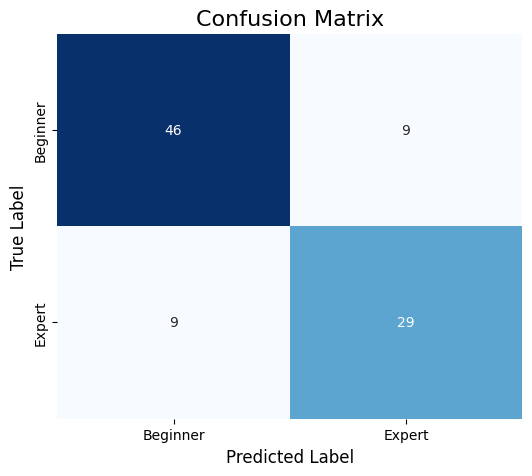

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# Initialize counters for True Positives (TP), False Positives (FP), and False Negatives (FN)
tp_beg = 0  # True positives for beginner
fp_beg = 0  # False positives for beginner
fn_beg = 0  # False negatives for beginner
tp_exp = 0  # True positives for expert
fp_exp = 0  # False positives for expert
fn_exp = 0  # False negatives for expert

correct = 0
beginner_correct = 0
expert_correct = 0

# Loop through test_cls_embeddings to classify and update confusion matrix
for test_cls_embedding in test_cls_embeddings:
    if test_cls_embedding[1] == 0:
        truth = "beginner"
    else:
        truth = "expert"

    # Normalize the vectors for cosine similarity
    cls_test_normalized = test_cls_embedding[0].cpu().detach().numpy() / np.linalg.norm(test_cls_embedding[0].cpu().detach().numpy())

    # Compare with beginner's mean vector
    cls_normalized_beg = mean_tensor_beginner.cpu().detach().numpy() / np.linalg.norm(mean_tensor_beginner.cpu().detach().numpy())
    similarity_beg = cosine_similarity(cls_test_normalized.reshape(1, -1), cls_normalized_beg.reshape(1, -1))[0][0]

    # Compare with expert's mean vector
    cls_normalized_exp = mean_tensor_expert.cpu().detach().numpy() / np.linalg.norm(mean_tensor_expert.cpu().detach().numpy())
    similarity_expert = cosine_similarity(cls_test_normalized.reshape(1, -1), cls_normalized_exp.reshape(1, -1))[0][0]

    # Predict the label based on similarity
    predicted = "beginner" if similarity_beg >= similarity_expert else "expert"

    # Update counters for confusion matrix based on prediction vs. truth
    if predicted == "beginner":
        if truth == "beginner":
            tp_beg += 1  # True Positive for beginner
        else:
            fp_beg += 1  # False Positive for beginner
            fn_exp += 1  # False Negative for expert
    elif predicted == "expert":
        if truth == "expert":
            tp_exp += 1  # True Positive for expert
        else:
            fp_exp += 1  # False Positive for expert
            fn_beg += 1  # False Negative for beginner

    # Count correct predictions
    if predicted == truth:
        correct += 1
        if truth == "beginner":
            beginner_correct += 1
        else:
            expert_correct += 1

# Calculate total True Positives, False Positives, and False Negatives
tp_total = tp_beg + tp_exp
fp_total = fp_beg + fp_exp
fn_total = fn_beg + fn_exp

# Calculate precision, recall, and F1 score for overall classification
precision_total = tp_total / (tp_total + fp_total) if (tp_total + fp_total) > 0 else 0
recall_total = tp_total / (tp_total + fn_total) if (tp_total + fn_total) > 0 else 0
f1_total = 2 * (precision_total * recall_total) / (precision_total + recall_total) if (precision_total + recall_total) > 0 else 0

# Print the overall F1 score
print(f"Overall F1 score: {f1_total:.4f}")

# Create confusion matrix
conf_matrix = np.array([[tp_beg, fp_exp],
                        [fn_beg, tp_exp]])

# Plot the confusion matrix using seaborn's heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Beginner", "Expert"], yticklabels=["Beginner", "Expert"], cbar=False)

# Set plot labels and title
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)

# Display the plot
plt.show()


Second method : BERT fine-tuned

In [6]:
import torch
from transformers import BertTokenizer

# Load the tokenizer globally
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class Dataset(torch.utils.data.Dataset):
    def __init__(self, df, labels, max_length=512):
        """
        Initialize the dataset for BERT processing.

        :param df: pandas DataFrame containing the text and label columns
        :param labels: dictionary or list of labels corresponding to the texts
        :param max_length: maximum sequence length for BERT input
        """
        self.max_length = max_length
        self.labels = []
        self.texts = []
        self.document_ids = []  # Store the document ids to link chunks

        for idx, text in enumerate(df['text']):
            if isinstance(text, str) and text:
                # Tokenize the text into tokens
                tokens = tokenizer.tokenize(text)

                # Manually chunk the tokenized text
                chunks = self.chunk_tokens(tokens)

                # For each chunk, encode it and append to the dataset
                for chunk in chunks:
                    encoded = tokenizer.encode_plus(
                        chunk,
                        add_special_tokens=True,  # Add [CLS] and [SEP] automatically
                        max_length=max_length,
                        padding='max_length',  # Pad to max_length
                        return_tensors='pt'     # Return as PyTorch tensor
                    )
                    self.texts.append(encoded)
                    self.labels.append(labels[df['label'].astype(str).iloc[idx]])  # Assuming labels is a dictionary or list
                    self.document_ids.append(idx)  # Track the document ID

        if len(self.labels) != len(self.texts):
            raise ValueError("Mismatch between number of texts and labels.")

    def chunk_tokens(self, tokens, chunk_size=510):
        """Chunk tokenized text into smaller parts."""
        chunks = []
        for i in range(0, len(tokens), chunk_size):
            chunk = tokens[i:i + chunk_size]
            chunks.append(chunk)
        return chunks

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        document_id = self.document_ids[idx]
        return text['input_ids'].squeeze(0), text['attention_mask'].squeeze(0), label, document_id


In [7]:
import torch
import torch.nn as nn
from transformers import BertForSequenceClassification

class BertClassifier(nn.Module):
    def __init__(self, num_classes, dropout=0.1):
        super(BertClassifier, self).__init__()

        # Use BertForSequenceClassification which includes BERT model + classification head
        self.bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes, output_hidden_states=True)
        self.dropout = nn.Dropout(dropout)  # Optional dropout layer
        self.cls_embeddings = None
        self.logits = None

    def forward(self, input_ids, attention_mask):
        """
        Forward pass through the BERT model and aggregate CLS embeddings by document.

        :param input_ids: Tensor of input token IDs (batch_size x seq_len)
        :param attention_mask: Tensor of attention masks (batch_size x seq_len)
        :param document_ids: Tensor of document IDs (batch_size), linking chunks from the same document
        :return: logits: Classification logits
        """
        # Forward pass through BERT model
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)

        # Extract the last hidden state (the last layer hidden states)
        last_hidden_state = outputs.hidden_states[-1]  # Shape: (batch_size, sequence_length, hidden_size)

        # Get the CLS embedding for each chunk (first token in each sequence)
        cls_embeddings = last_hidden_state[:, 0, :]  # Shape: (batch_size, hidden_size)

        # Apply dropout
        cls_embeddings = self.dropout(cls_embeddings)

        self.cls_embeddings = cls_embeddings

        logits = self.bert.classifier(cls_embeddings)  # Apply classification head
        self.logits = logits

        return logits




In [8]:
import torch
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.optim import Adam
from tqdm import tqdm
import torch.nn as nn
from transformers import BertTokenizer

# Load the tokenizer globally
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print(f"Early stopping triggered after {self.patience} epochs without improvement.")

def train(model, train_data, val_data, labels, learning_rate, epochs):
    # Initialize datasets
    train_dataset = Dataset(train_data, labels)
    val_dataset = Dataset(val_data, labels)

    def collate_fn(batch):

        input_ids = pad_sequence([item[0] for item in batch], batch_first=True, padding_value=tokenizer.pad_token_id)
        attention_mask = pad_sequence([item[1] for item in batch], batch_first=True, padding_value=0)
        labels = torch.tensor([item[2] for item in batch])
        document_ids = torch.tensor([item[3] for item in batch])
        return {'input_ids': input_ids, 'attention_mask': attention_mask, 'document_ids': document_ids}, labels

    # DataLoader
    train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn, num_workers=2)
    val_dataloader = DataLoader(val_dataset, batch_size=2, collate_fn=collate_fn, num_workers=2)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = Adam(model.parameters(), lr=learning_rate)

    cls_embeddings_with_text_train = []
    cls_embeddings_with_text_val = []

    early_stopping = EarlyStopping(patience=5, verbose=True)

    # Gradient accumulation steps
    accumulation_steps = 4  # Adjust this based on your needs

    for epoch_num in range(epochs):
        total_acc_train, total_loss_train = 0, 0
        model.train()

        for i, (train_input, train_label) in enumerate(tqdm(train_dataloader)):
            train_label = train_label.to(device)
            input_ids = train_input['input_ids'].to(device)
            attention_mask = train_input['attention_mask'].to(device)
            document_ids = train_input['document_ids'].to(device)

            # Forward pass
            output = model(input_ids, attention_mask)
            batch_loss = criterion(output, train_label)
            total_loss_train += batch_loss.item()

            # Calculate accuracy
            total_correct_train = (output.argmax(dim=1) == train_label).sum().item()
            total_acc_train += total_correct_train

            # Normalize loss to account for accumulation
            batch_loss = batch_loss / accumulation_steps
            batch_loss.backward()

            if (i + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

            # Store CLS embeddings and text for further analysis
            # TODO. : double check the below function
            cls_embeddings_with_text_train.extend(zip(
                [tokenizer.decode(ids, skip_special_tokens=True) for ids in input_ids],
                model.cls_embeddings.detach().cpu().numpy(),
                train_label.cpu().numpy()
            ))

        # Validation loop
        total_acc_val, total_loss_val = 0, 0
        model.eval()

        with torch.no_grad():
            for val_input, val_label in val_dataloader:
                val_label = val_label.to(device)
                input_ids = val_input['input_ids'].to(device)
                attention_mask = val_input['attention_mask'].to(device)
                document_ids = val_input['document_ids'].to(device)

                output = model(input_ids, attention_mask)
                batch_loss = criterion(output, val_label)
                total_loss_val += batch_loss.item()

                # Calculate accuracy for validation
                total_correct_val = (output.argmax(dim=1) == val_label).sum().item()
                total_acc_val += total_correct_val

                # Store CLS embeddings and text for validation
                cls_embeddings_with_text_val.extend(zip(
                    [tokenizer.decode(ids, skip_special_tokens=True) for ids in input_ids],
                    model.cls_embeddings.detach().cpu().numpy(),
                    val_label.cpu().numpy()
                ))

        # Calculate average losses and accuracies
        avg_train_loss = total_loss_train / len(train_dataloader)
        avg_train_acc = total_acc_train / (len(train_dataloader) * train_dataloader.batch_size)
        avg_val_loss = total_loss_val / len(val_dataloader)
        avg_val_acc = total_acc_val / (len(val_dataloader) * val_dataloader.batch_size)

        print(f'Epochs: {epoch_num + 1} | Train Loss: {avg_train_loss:.3f} | Train Accuracy: {avg_train_acc:.3f} | Val Loss: {avg_val_loss:.3f} | Val Accuracy: {avg_val_acc:.3f}')

        # Print which parameters were updated
        print("Updated parameters during this epoch:")
        updated_params = []
        for name, param in model.named_parameters():
            if param.grad is not None:  # Only parameters that were updated will have gradients
                updated_params.append(name)
        print(f"Parameters updated: {updated_params}")

        # Check for early stopping
        early_stopping(avg_val_loss)
        if early_stopping.early_stop:
            print("Stopping training early!")
            break

    return cls_embeddings_with_text_train, cls_embeddings_with_text_val



In [9]:
EPOCHS = 20
num_classes = 2
model = BertClassifier(num_classes=num_classes)
LR = 1e-05


labels = {
    '0': 0,
    '1': 1
}

cls_embeddings_with_text_train,cls_embeddings_with_text_val = train(model, train_df, val_df, labels, LR, EPOCHS)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 1054/1054 [01:06<00:00, 15.88it/s]


Epochs: 1 | Train Loss: 0.289 | Train Accuracy: 0.880 | Val Loss: 0.172 | Val Accuracy: 0.934
Updated parameters during this epoch:
Parameters updated: ['bert.bert.embeddings.word_embeddings.weight', 'bert.bert.embeddings.position_embeddings.weight', 'bert.bert.embeddings.token_type_embeddings.weight', 'bert.bert.embeddings.LayerNorm.weight', 'bert.bert.embeddings.LayerNorm.bias', 'bert.bert.encoder.layer.0.attention.self.query.weight', 'bert.bert.encoder.layer.0.attention.self.query.bias', 'bert.bert.encoder.layer.0.attention.self.key.weight', 'bert.bert.encoder.layer.0.attention.self.key.bias', 'bert.bert.encoder.layer.0.attention.self.value.weight', 'bert.bert.encoder.layer.0.attention.self.value.bias', 'bert.bert.encoder.layer.0.attention.output.dense.weight', 'bert.bert.encoder.layer.0.attention.output.dense.bias', 'bert.bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.bert.encoder.layer.0.intermediate.dens

100%|██████████| 1054/1054 [01:05<00:00, 16.19it/s]


Epochs: 2 | Train Loss: 0.120 | Train Accuracy: 0.957 | Val Loss: 0.169 | Val Accuracy: 0.931
Updated parameters during this epoch:
Parameters updated: ['bert.bert.embeddings.word_embeddings.weight', 'bert.bert.embeddings.position_embeddings.weight', 'bert.bert.embeddings.token_type_embeddings.weight', 'bert.bert.embeddings.LayerNorm.weight', 'bert.bert.embeddings.LayerNorm.bias', 'bert.bert.encoder.layer.0.attention.self.query.weight', 'bert.bert.encoder.layer.0.attention.self.query.bias', 'bert.bert.encoder.layer.0.attention.self.key.weight', 'bert.bert.encoder.layer.0.attention.self.key.bias', 'bert.bert.encoder.layer.0.attention.self.value.weight', 'bert.bert.encoder.layer.0.attention.self.value.bias', 'bert.bert.encoder.layer.0.attention.output.dense.weight', 'bert.bert.encoder.layer.0.attention.output.dense.bias', 'bert.bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.bert.encoder.layer.0.intermediate.dens

100%|██████████| 1054/1054 [01:05<00:00, 16.20it/s]


Epochs: 3 | Train Loss: 0.048 | Train Accuracy: 0.986 | Val Loss: 0.182 | Val Accuracy: 0.949
Updated parameters during this epoch:
Parameters updated: ['bert.bert.embeddings.word_embeddings.weight', 'bert.bert.embeddings.position_embeddings.weight', 'bert.bert.embeddings.token_type_embeddings.weight', 'bert.bert.embeddings.LayerNorm.weight', 'bert.bert.embeddings.LayerNorm.bias', 'bert.bert.encoder.layer.0.attention.self.query.weight', 'bert.bert.encoder.layer.0.attention.self.query.bias', 'bert.bert.encoder.layer.0.attention.self.key.weight', 'bert.bert.encoder.layer.0.attention.self.key.bias', 'bert.bert.encoder.layer.0.attention.self.value.weight', 'bert.bert.encoder.layer.0.attention.self.value.bias', 'bert.bert.encoder.layer.0.attention.output.dense.weight', 'bert.bert.encoder.layer.0.attention.output.dense.bias', 'bert.bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.bert.encoder.layer.0.intermediate.dens

100%|██████████| 1054/1054 [01:05<00:00, 16.18it/s]


Epochs: 4 | Train Loss: 0.023 | Train Accuracy: 0.993 | Val Loss: 0.185 | Val Accuracy: 0.956
Updated parameters during this epoch:
Parameters updated: ['bert.bert.embeddings.word_embeddings.weight', 'bert.bert.embeddings.position_embeddings.weight', 'bert.bert.embeddings.token_type_embeddings.weight', 'bert.bert.embeddings.LayerNorm.weight', 'bert.bert.embeddings.LayerNorm.bias', 'bert.bert.encoder.layer.0.attention.self.query.weight', 'bert.bert.encoder.layer.0.attention.self.query.bias', 'bert.bert.encoder.layer.0.attention.self.key.weight', 'bert.bert.encoder.layer.0.attention.self.key.bias', 'bert.bert.encoder.layer.0.attention.self.value.weight', 'bert.bert.encoder.layer.0.attention.self.value.bias', 'bert.bert.encoder.layer.0.attention.output.dense.weight', 'bert.bert.encoder.layer.0.attention.output.dense.bias', 'bert.bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.bert.encoder.layer.0.intermediate.dens

100%|██████████| 1054/1054 [01:05<00:00, 16.17it/s]


Epochs: 5 | Train Loss: 0.005 | Train Accuracy: 0.999 | Val Loss: 0.228 | Val Accuracy: 0.953
Updated parameters during this epoch:
Parameters updated: ['bert.bert.embeddings.word_embeddings.weight', 'bert.bert.embeddings.position_embeddings.weight', 'bert.bert.embeddings.token_type_embeddings.weight', 'bert.bert.embeddings.LayerNorm.weight', 'bert.bert.embeddings.LayerNorm.bias', 'bert.bert.encoder.layer.0.attention.self.query.weight', 'bert.bert.encoder.layer.0.attention.self.query.bias', 'bert.bert.encoder.layer.0.attention.self.key.weight', 'bert.bert.encoder.layer.0.attention.self.key.bias', 'bert.bert.encoder.layer.0.attention.self.value.weight', 'bert.bert.encoder.layer.0.attention.self.value.bias', 'bert.bert.encoder.layer.0.attention.output.dense.weight', 'bert.bert.encoder.layer.0.attention.output.dense.bias', 'bert.bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.bert.encoder.layer.0.intermediate.dens

100%|██████████| 1054/1054 [01:05<00:00, 16.18it/s]


Epochs: 6 | Train Loss: 0.002 | Train Accuracy: 1.000 | Val Loss: 0.240 | Val Accuracy: 0.953
Updated parameters during this epoch:
Parameters updated: ['bert.bert.embeddings.word_embeddings.weight', 'bert.bert.embeddings.position_embeddings.weight', 'bert.bert.embeddings.token_type_embeddings.weight', 'bert.bert.embeddings.LayerNorm.weight', 'bert.bert.embeddings.LayerNorm.bias', 'bert.bert.encoder.layer.0.attention.self.query.weight', 'bert.bert.encoder.layer.0.attention.self.query.bias', 'bert.bert.encoder.layer.0.attention.self.key.weight', 'bert.bert.encoder.layer.0.attention.self.key.bias', 'bert.bert.encoder.layer.0.attention.self.value.weight', 'bert.bert.encoder.layer.0.attention.self.value.bias', 'bert.bert.encoder.layer.0.attention.output.dense.weight', 'bert.bert.encoder.layer.0.attention.output.dense.bias', 'bert.bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.bert.encoder.layer.0.intermediate.dens

100%|██████████| 1054/1054 [01:05<00:00, 16.16it/s]


Epochs: 7 | Train Loss: 0.001 | Train Accuracy: 1.000 | Val Loss: 0.251 | Val Accuracy: 0.953
Updated parameters during this epoch:
Parameters updated: ['bert.bert.embeddings.word_embeddings.weight', 'bert.bert.embeddings.position_embeddings.weight', 'bert.bert.embeddings.token_type_embeddings.weight', 'bert.bert.embeddings.LayerNorm.weight', 'bert.bert.embeddings.LayerNorm.bias', 'bert.bert.encoder.layer.0.attention.self.query.weight', 'bert.bert.encoder.layer.0.attention.self.query.bias', 'bert.bert.encoder.layer.0.attention.self.key.weight', 'bert.bert.encoder.layer.0.attention.self.key.bias', 'bert.bert.encoder.layer.0.attention.self.value.weight', 'bert.bert.encoder.layer.0.attention.self.value.bias', 'bert.bert.encoder.layer.0.attention.output.dense.weight', 'bert.bert.encoder.layer.0.attention.output.dense.bias', 'bert.bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.bert.encoder.layer.0.intermediate.dens

In [10]:
import torch
import numpy as np
from tqdm import tqdm  # Optional, for progress bar
import torch
from torch import nn






def evaluate_testset(model, test_data, labels):
    test = Dataset(test_data, labels)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=1, shuffle=False)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    model.to(device)

    model.eval()

    total_acc_test = 0
    cls_embeddings = []
    total_samples = 0

    with torch.no_grad():
        # Iterate over each batch in the test set
        for batch in tqdm(test_dataloader, desc="Evaluating"):
            # Extract batch data
            input_ids, attention_mask, test_label, document_ids = batch

            if input_ids is None:  # Skip any empty batches
                continue

            # Move to device
            test_label = test_label.to(device)
            attention_mask = attention_mask.to(device)
            input_ids = input_ids.to(device)

            # Forward pass through the model
            logits = model(input_ids, attention_mask)
            #print(test_label)
            #print(logits)

            '''
            logit_class_1 = logits[0, 1]
            #print(logit_class_1)
            sigmoid = nn.Sigmoid()
            expertise_score = sigmoid(logit_class_1)
            print(test_label)
            print(logit_class_1)
            print(expertise_score)
            '''
            '''

            temperature = 3.0  # A temperature value > 1 softens the probabilities

            logits_scaled = logits / temperature
            sigmoid = nn.Sigmoid()
            prob = sigmoid(logits_scaled)
            print(test_label)
            print(prob[0, 1])
            '''

            #print(logits)
            # Get predicted class labels from logits
            predicted_labels = logits.argmax(dim=1)


            #print(predicted_labels)

            # Store the CLS embeddings along with their document_id
            for cls_embedding, doc_id in zip(model.cls_embeddings, document_ids):
                # Append a tuple (cls_embedding, document_id) to the list
                cls_embeddings.append((cls_embedding, doc_id.item()))

            # Calculate accuracy for this batch (based on the predicted labels)
            correct_preds = (predicted_labels == test_label).sum().item()
            total_acc_test += correct_preds
            total_samples += test_label.size(0)  # Add number of samples in the current batch

    # Calculate overall accuracy
    accuracy = total_acc_test / total_samples

    # Print the overall accuracy
    print(f'Test Accuracy: {accuracy: .3f}')

    return cls_embeddings


In [11]:
cls_embeddings_test = evaluate_testset(model, test_df, labels)

Evaluating: 100%|██████████| 261/261 [00:02<00:00, 107.34it/s]

Test Accuracy:  0.939


In [12]:
tensors_list_beginner =  [torch.tensor(t[1]) for t in cls_embeddings_with_text_train if t[2].item() == 0]  # Convert to tensors
tensors_list_expert =  [torch.tensor(t[1]) for t in cls_embeddings_with_text_train if t[2].item() == 1]  # Convert to tensors
mean_tensor_beginner = torch.mean(torch.stack(tensors_list_beginner), dim=0)
mean_tensor_expert = torch.mean(torch.stack(tensors_list_expert), dim=0)

In [13]:
# Initialize a defaultdict to accumulate vectors and count for each label
from collections import defaultdict

aggregated = defaultdict(lambda: {'sum': [], 'count': 0})

# Group by label, accumulate sum of vectors, and count the occurrences
for cls_embedding, doc_id in cls_embeddings_test:
    aggregated[doc_id]['sum'].append(cls_embedding)
    aggregated[doc_id]['count'] += 1

# Calculate the mean (average) for each group
for doc_id in aggregated:
    aggregated[doc_id]['mean'] = torch.mean(torch.stack(aggregated[doc_id]['sum']), dim=0)



In [14]:
from sklearn.metrics.pairwise import cosine_similarity
correct = 0
beginner_correct = 0
expert_correct = 0


for doc_id in aggregated.keys() :
  test_mean_cls_embedding = aggregated[doc_id]['mean']

  if test_df['label'][doc_id] == 0 :
    truth = "beginner"

  elif test_df['label'][doc_id] == 1 :
    truth = "expert"

  cls_test_normalized = test_mean_cls_embedding.cpu().detach().numpy() / np.linalg.norm(test_mean_cls_embedding.cpu().detach().numpy())

  cls_beginner_normalized = mean_tensor_beginner.cpu().detach().numpy() / np.linalg.norm(mean_tensor_beginner.cpu().detach().numpy())
  similarity_beg = cosine_similarity(cls_test_normalized.reshape(1, -1), cls_beginner_normalized.reshape(1, -1))[0][0]

  cls_expert_normalized = mean_tensor_expert.cpu().detach().numpy() / np.linalg.norm(mean_tensor_expert.cpu().detach().numpy())
  similarity_expert = cosine_similarity(cls_test_normalized.reshape(1, -1), cls_expert_normalized.reshape(1, -1))[0][0]


  if similarity_beg > similarity_expert and truth == "beginner" :
    beginner_correct += 1
    correct += 1
  elif similarity_beg < similarity_expert and truth == "expert" :
    expert_correct += 1
    correct += 1

print("expert correct : ", expert_correct/len(test_df[test_df['label'] == 1]),"\n")
print("beginner correct : ", beginner_correct/len(test_df[test_df['label'] == 0]),"\n")
print("correct : ", correct/len(test_df),"\n")

expert correct :  0.9787234042553191 

beginner correct :  0.9454545454545454 

correct :  0.9607843137254902 



Overall F1 score: 0.9608


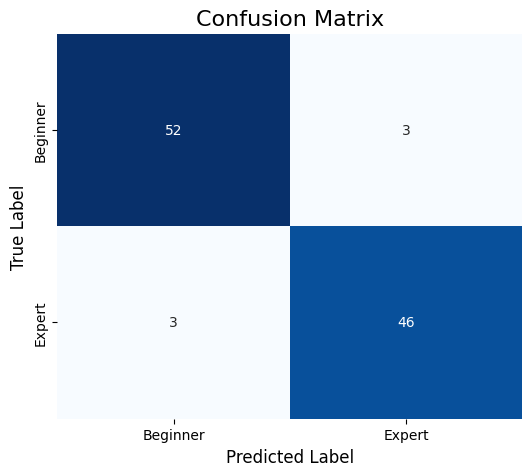

In [15]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# Initialize counters for the confusion matrix components
tp_beg = 0  # True positives for beginner
fp_beg = 0  # False positives for beginner
fn_beg = 0  # False negatives for beginner
tp_exp = 0  # True positives for expert
fp_exp = 0  # False positives for expert
fn_exp = 0  # False negatives for expert

# Iterate over the aggregated dictionary (you can adjust based on your data structure)
for doc_id in aggregated.keys():
    test_cls_embedding = aggregated[doc_id]['mean']

    # Determine the ground truth label (beginner or expert)
    truth = "beginner" if test_df['label'][doc_id] == 0 else "expert"

    # Normalize vectors
    cls_test_normalized = test_cls_embedding.cpu().detach().numpy() / np.linalg.norm(test_cls_embedding.cpu().detach().numpy())
    cls_normalized_beg = mean_tensor_beginner.cpu().detach().numpy() / np.linalg.norm(mean_tensor_beginner.cpu().detach().numpy())
    cls_normalized_exp = mean_tensor_expert.cpu().detach().numpy() / np.linalg.norm(mean_tensor_expert.cpu().detach().numpy())

    # Compute cosine similarities
    similarity_beg = cosine_similarity(cls_test_normalized.reshape(1, -1), cls_normalized_beg.reshape(1, -1))[0][0]
    similarity_exp = cosine_similarity(cls_test_normalized.reshape(1, -1), cls_normalized_exp.reshape(1, -1))[0][0]

    # Classify based on similarities
    predicted = "beginner" if similarity_beg > similarity_exp else "expert"

    # Update confusion matrix counters based on prediction and truth
    if predicted == "beginner":
        if truth == "beginner":
            tp_beg += 1
        else:
            fp_beg += 1
    else:  # predicted == "expert"
        if truth == "expert":
            tp_exp += 1
        else:
            fp_exp += 1

    if predicted != truth:  # False negatives
        if truth == "beginner":
            fn_beg += 1
        else:
            fn_exp += 1

tp_total = tp_beg + tp_exp
fp_total = fp_beg + fp_exp
fn_total = fn_beg + fn_exp

# Calculate precision, recall, and F1 score for overall classification
precision_total = tp_total / (tp_total + fp_total) if (tp_total + fp_total) > 0 else 0
recall_total = tp_total / (tp_total + fn_total) if (tp_total + fn_total) > 0 else 0
f1_total = 2 * (precision_total * recall_total) / (precision_total + recall_total) if (precision_total + recall_total) > 0 else 0

# Print the overall F1 score
print(f"Overall F1 score: {f1_total:.4f}")

# Create confusion matrix
conf_matrix = np.array([[tp_beg, fp_exp],
                        [fn_beg, tp_exp]])

# Plot the confusion matrix using seaborn's heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Beginner", "Expert"], yticklabels=["Beginner", "Expert"], cbar=False)

# Set plot labels and title
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)

# Display the plot
plt.show()
